## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [65]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nx, ny = 9, 6

In [3]:
def calibrate_camera(imgs_path):
    images = glob.glob(imgs_path)
    objpoints, imgpoints = [], []
    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

In [4]:
objpoints, imgpoints = calibrate_camera('camera_cal/cali*.jpg')

In [6]:
# def undistort_unwarp(images_path, objpoints, imgpoints, nx, ny):
#     images = glob.glob(images_path)
#     for fname in images:
#         img = cv2.imread(fname)
#         ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
#         undist = cv2.undistort(img, mtx, dist, None, mtx)
#         ret, corners = cv2.findChessboardCorners(undist, (nx, ny), None)
#         if ret == True:
#             img = cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
#             offset = 100
#             src = np.float32([corners[0], corners[nx-1], corners[-nx], corners[-1]])
#             dst = np.float32([[offset, offset],
#                               [img.shape[1] - offset, offset],
#                               [offset, img.shape[0] - offset],
#                               [img.shape[1] - offset, img.shape[0] - offset]])
#             M = cv2.getPerspectiveTransform(src, dst)
#             warped = cv2.warpPerspective(img, M, undist.shape[1::-1], flags=cv2.INTER_LINEAR)
#             cv2.imshow("Warped", warped)
#             cv2.waitKey(500)
#     cv2.destroyAllWindows()

In [385]:
#undistort_unwarp('camera_cal/cali*.jpg', objpoints, imgpoints, nx, ny)

In [386]:
img = cv2.imread('test_images/test6.jpg')

In [387]:
!ls test_images/

straight_lines1.jpg  test1.jpg	test3.jpg  test5.jpg
straight_lines2.jpg  test2.jpg	test4.jpg  test6.jpg


In [67]:
cv2.namedWindow("img", cv2.WINDOW_NORMAL)
#cv2.resizeWindow("img", 600, 600)
cv2.imshow("img", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [388]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

In [389]:
undist = cv2.undistort(img, mtx, dist, None, mtx)

In [390]:
offset = 10

In [391]:
cv2.namedWindow("undist", cv2.WINDOW_NORMAL)
cv2.imshow("undist", undist)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
# pts = np.array([[566,457],
#                 [710, 457],
#                 [1215, undist.shape[0]],
#                 [262, undist.shape[0]]],
#                np.int32)

# pts = pts.reshape((-1, 1, 2))

# pol = cv2.polylines(undist, [pts], True, (0, 255, 255))

# cv2.namedWindow("undist", cv2.WINDOW_NORMAL)
# cv2.resizeWindow("undist", 600, 600)
# cv2.imshow("undist", pol)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [392]:
src = np.float32([[566, 457],
                  [750, 457],
                  [1215, undist.shape[0]],
                  [130, undist.shape[0]]
                 ])


dst = np.float32([[offset, offset],
                 [undist.shape[1] - offset, offset],
                 [undist.shape[1] - offset, undist.shape[0] - offset],
                 [offset, undist.shape[0] - offset]])

In [393]:
Minv = cv2.getPerspectiveTransform(dst, src)

In [394]:
M = cv2.getPerspectiveTransform(src, dst)

In [395]:
warped = cv2.warpPerspective(undist, M, undist.shape[1::-1], flags=cv2.INTER_LINEAR)

In [396]:
cv2.namedWindow("warped", cv2.WINDOW_NORMAL)
cv2.resizeWindow("warped", 600, 600)
cv2.imshow("warped", warped)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Color Gradients

## Threshold gradient

In [397]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x',  thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelabs = np.abs(sobel)
    scaledsobel = np.uint8(255*sobelabs/np.max(sobelabs))
    sbinary = np.zeros_like(scaledsobel)
    sbinary[(scaledsobel >= thresh[0]) & (scaledsobel <= thresh[1])] = 1
    return sbinary

In [398]:
gradx_binary = abs_sobel_thresh(warped, sobel_kernel=5, orient='x', thresh=(20, 100))

In [399]:
grady_binary = abs_sobel_thresh(warped, sobel_kernel=5, orient='y', thresh=(20, 100))

In [400]:
grad_binary = abs_sobel_thresh(warped, sobel_kernel=5, orient='x', thresh=(20, 100))

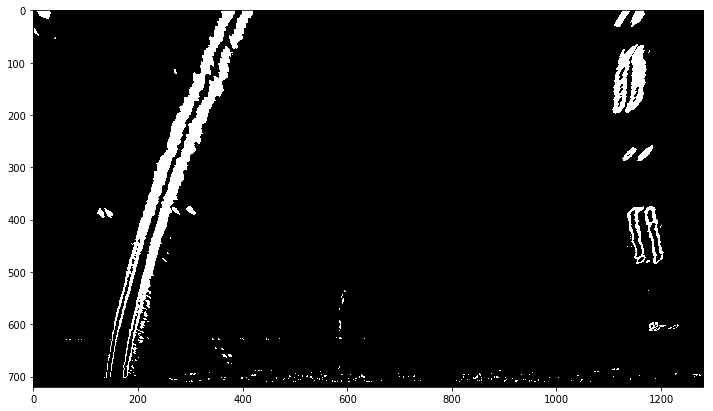

In [401]:
plt.figure(figsize=(12,10))
plt.imshow(grad_binary, cmap='gray')

## Magnitude of the Gradient

In [402]:
def mag_thresh(img, sobel_kernel=5, mag_thresh=(20, 200)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    magnitude = np.sqrt((sobelx)**2 + (sobely)**2)
    scaledsobel = np.uint8(255*magnitude/np.max(magnitude))
    sbinary = np.zeros_like(scaledsobel)
    sbinary[(scaledsobel >= mag_thresh[0]) & (scaledsobel <= mag_thresh[1])] = 1
    return sbinary

In [403]:
mag_img = mag_thresh(warped)

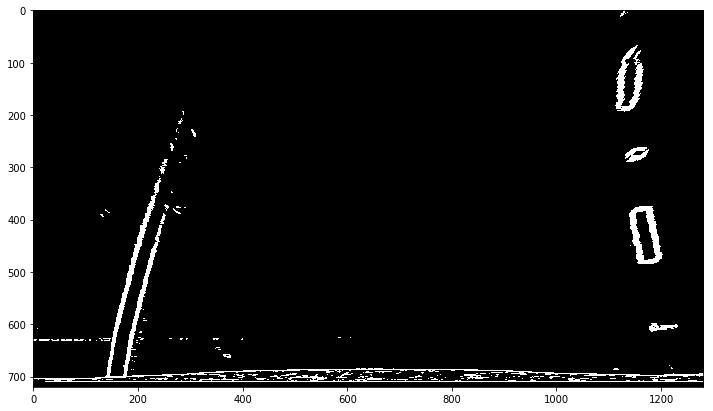

In [404]:
plt.figure(figsize=(12,10))
plt.imshow(mag_img, cmap='gray')

In [405]:
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

In [406]:
dir_binary = dir_threshold(warped, sobel_kernel=5, thresh=(0.7, 1.3))

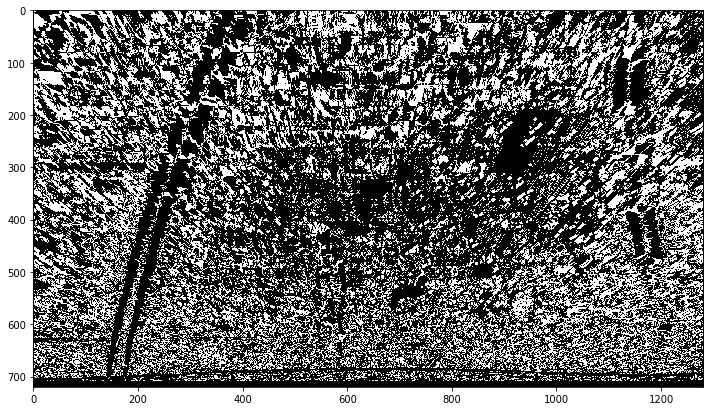

In [407]:
plt.figure(figsize=(12,10))
plt.imshow(dir_binary, cmap='gray')

In [408]:
combined = np.zeros_like(dir_binary)

In [409]:
combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_img == 1) & (dir_binary== 1))] = 1

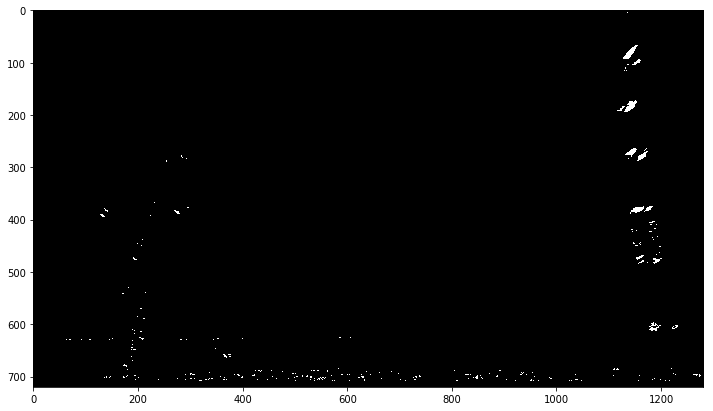

In [410]:
plt.figure(figsize=(12,10))
plt.imshow(combined, cmap='gray')

# Color Thresholding

In [411]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    return binary_output

In [412]:
hls_binary = hls_select(warped, thresh=(90, 255))

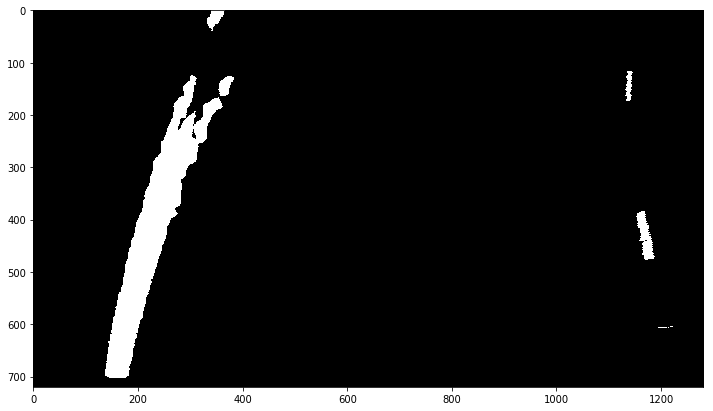

In [413]:
plt.figure(figsize=(12, 10))
plt.imshow(hls_binary, cmap='gray')

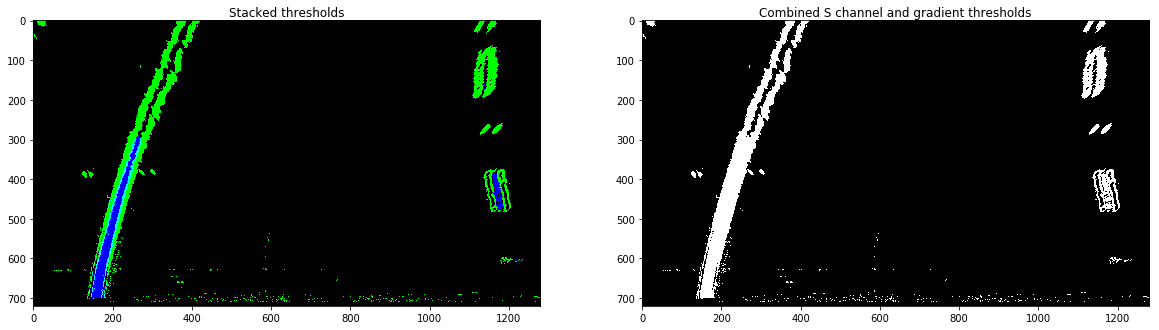

In [414]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

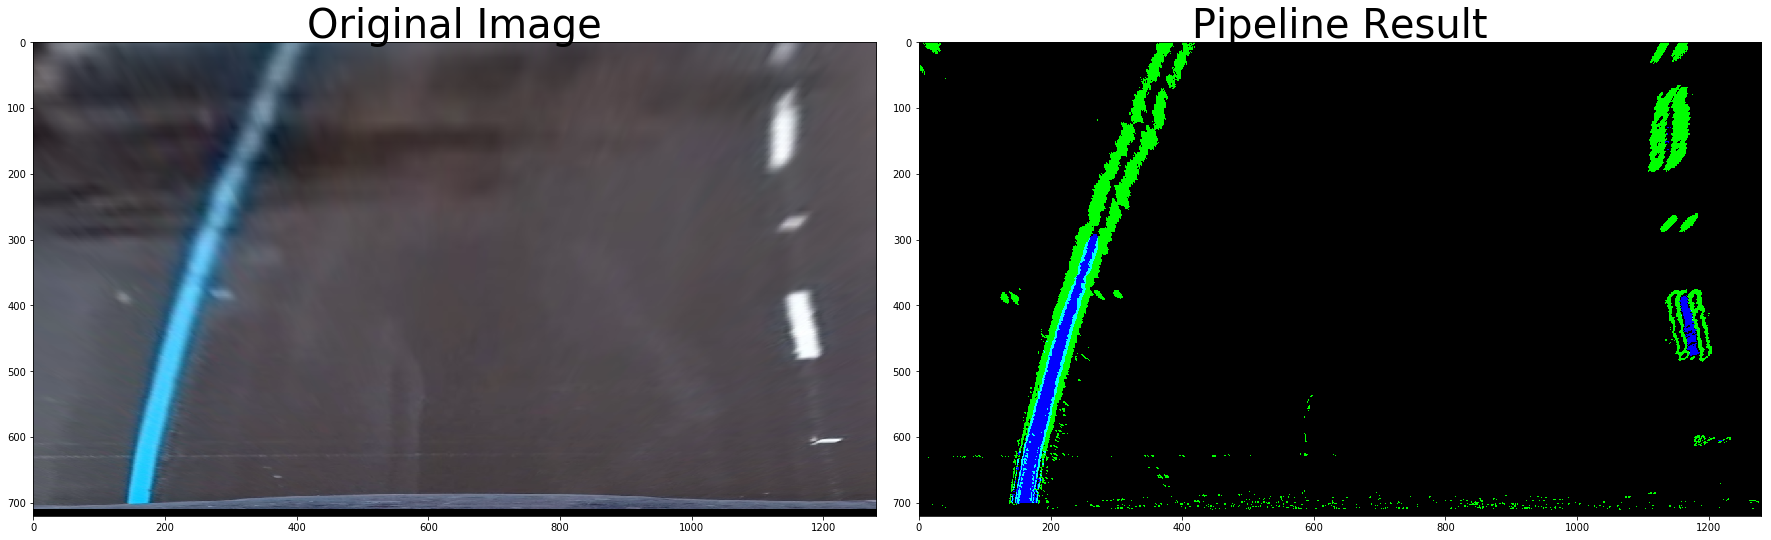

In [415]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    
result = pipeline(warped)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Detect lane pixels and fit to find the lane boundary.

In [416]:
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)

In [417]:
#histogram = np.sum(result[result.shape[0]//2:,:], axis=0)

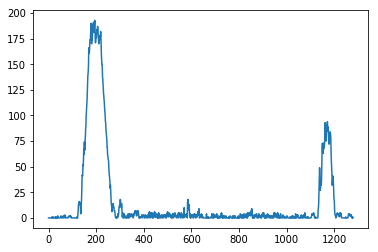

In [418]:
plt.plot(histogram)

# Sliding Window and Fit Polynomial

In [419]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint]) # take the peak value in the left
    print("Leftx base value: ", leftx_base)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint  # take the peak value in the right
    print("Rightx base value: ", rightx_base)
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    print("Nonzero matrix", nonzero)
    nonzeroy = np.array(nonzero[0]) # y value
    nonzerox = np.array(nonzero[1]) # x value
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        print("win_y_low value : ", win_y_low)
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0, 255, 0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0, 255, 0), 3) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [420]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(combined_binary)

# Fit a second order polynomial to each using `np.polyfit`
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )

Leftx base value:  194
Rightx base value:  1172
Nonzero matrix (array([  0,   0,   0, ..., 710, 710, 710]), array([   5,    6,   10, ...,  959, 1062, 1063]))
win_y_low value :  640
win_y_low value :  560
win_y_low value :  480
win_y_low value :  400
win_y_low value :  320
win_y_low value :  240
win_y_low value :  160
win_y_low value :  80
win_y_low value :  0


In [421]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


Leftx base value:  194
Rightx base value:  1172
Nonzero matrix (array([  0,   0,   0, ..., 710, 710, 710]), array([   5,    6,   10, ...,  959, 1062, 1063]))
win_y_low value :  640
win_y_low value :  560
win_y_low value :  480
win_y_low value :  400
win_y_low value :  320
win_y_low value :  240
win_y_low value :  160
win_y_low value :  80
win_y_low value :  0


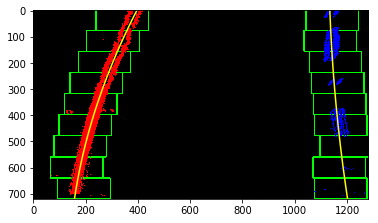

In [422]:
out_img = fit_polynomial(combined_binary)

plt.imshow(out_img)

# Search from Prior

In [423]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [424]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                      (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty

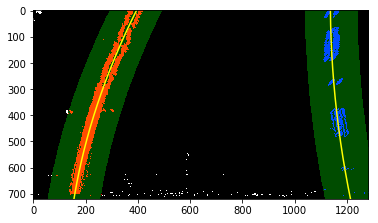

In [425]:
result, left_fitx, right_fitx, ploty = search_around_poly(combined_binary)

# View your output
plt.imshow(result)

# Determine the curvature of the lane and vehicle position with respect to center.

$f(y) = Ay^2 + By + C $

In [426]:
def measure_curvature_pixels():
    leftx, lefty, rightx, righty, _ = find_lane_pixels(combined_binary)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [427]:
left_curverad, right_curverad = measure_curvature_pixels()

Leftx base value:  194
Rightx base value:  1172
Nonzero matrix (array([  0,   0,   0, ..., 710, 710, 710]), array([   5,    6,   10, ...,  959, 1062, 1063]))
win_y_low value :  640
win_y_low value :  560
win_y_low value :  480
win_y_low value :  400
win_y_low value :  320
win_y_low value :  240
win_y_low value :  160
win_y_low value :  80
win_y_low value :  0


In [428]:
left_curverad

2032.2666404697118

In [429]:
right_curverad

6580.0055324758196

In [430]:
def measure_curvature_real(img):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    leftx, lefty, rightx, righty, _ = find_lane_pixels(img)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [431]:
left_curverad, right_curverad = measure_curvature_real(combined_binary)

Leftx base value:  194
Rightx base value:  1172
Nonzero matrix (array([  0,   0,   0, ..., 710, 710, 710]), array([   5,    6,   10, ...,  959, 1062, 1063]))
win_y_low value :  640
win_y_low value :  560
win_y_low value :  480
win_y_low value :  400
win_y_low value :  320
win_y_low value :  240
win_y_low value :  160
win_y_low value :  80
win_y_low value :  0


In [432]:
left_curverad

646.47348253519965

In [433]:
right_curverad

2090.8313786398148

In [434]:
leftx, lefty, rightx, righty, _ = find_lane_pixels(combined_binary)

Leftx base value:  194
Rightx base value:  1172
Nonzero matrix (array([  0,   0,   0, ..., 710, 710, 710]), array([   5,    6,   10, ...,  959, 1062, 1063]))
win_y_low value :  640
win_y_low value :  560
win_y_low value :  480
win_y_low value :  400
win_y_low value :  320
win_y_low value :  240
win_y_low value :  160
win_y_low value :  80
win_y_low value :  0


In [435]:
warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])


pts = np.hstack((pts_left, pts_right))


cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))


newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

In [437]:
cv2.namedWindow("final", cv2.WINDOW_NORMAL)
cv2.resizeWindow("final", 600, 600)
cv2.imshow("final", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Videos

In [438]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [440]:
!ls 

camera_cal  Project_v80519.ipynb  project_video.mp4  Python  test_images


In [444]:
def process_image(initial_img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    offset = 10
    src = np.float32([[566, 457],
                  [750, 457],
                  [1215, undist.shape[0]],
                  [130, undist.shape[0]]
                 ])


    dst = np.float32([[offset, offset],
                 [undist.shape[1] - offset, offset],
                 [undist.shape[1] - offset, undist.shape[0] - offset],
                 [offset, undist.shape[0] - offset]])
    
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, undist.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])


    pts = np.hstack((pts_left, pts_right))


    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))


    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    
    
    
    
    return img

In [445]:
!ls

camera_cal  Project_v80519.ipynb  project_video.mp4  Python  test_images


In [446]:
video_capture = cv2.VideoCapture('project_video.mp4')
while (video_capture.isOpened()):
    ret, frame = video_capture.read()
    if ret:
        
        output = process_image(frame)
        cv2.imshow('frame',output)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
# Release everything if job is finished
video_capture.release()
cv2.destroyAllWindows()

In [447]:

white_output = 'project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video.mp4.
Moviepy - Writing video project_video.mp4



Moviepy - Done !
Moviepy - video ready project_video.mp4
CPU times: user 14min 29s, sys: 711 ms, total: 14min 29s
Wall time: 13min 29s
